In [97]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

In [98]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL_1 = "Horse Power"
TARGET_COL_2 = "daily_consumption" 

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)


# Part 1 (50 points): Fuel Consumption → Horsepower Prediction
Dataset: Fuel Consumption Based on HP (Kaggle)  
Goal: Build regression models to predict horsepower (HP) based on fuel consumption features.

## 1.1 Load and inspect the dataset

In [85]:
# • Load the CSV into a pandas DataFrame.
DATA_PATH = "FuelEconomy.csv"

df = pd.read_csv(DATA_PATH)

# • Display column names, shape, and summary statistics (describe()).
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

# • Identify missing values (if any) and clearly state how you handle them
print("\nMissing values per column:")
display(df.isna().sum())

Shape: (100, 2)

Columns:
['Horse Power', 'Fuel Economy (MPG)']


,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739



Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


Horse Power           0
Fuel Economy (MPG)    0
dtype: int64

## 1.2 Train/Test split (70% / 30% random)
- `prepare_xy(df_in)` splits the dataset into X (input features) and y (target variable)
- `split_data(X, y)`: Randomly split the dataset into 70% training and 30% testing.
## 1.3 Model training: Linear + Polynomial regression (15 points)
- `compute_metrics(y_true, y_pred)`computes 3 core regression evaluation metrics.
- `print_fitted_equation(...)`: Prints the fitted regression model equation using the learned coefficients. 
## 1.4 Model evaluation (train and test) (10 points)
- `run_models_and_evaluate(...)`: Returns a clean results table for easy comparison


Scenario:  Fuel Consumption → Horsepower Prediction
Model: Linear Regression


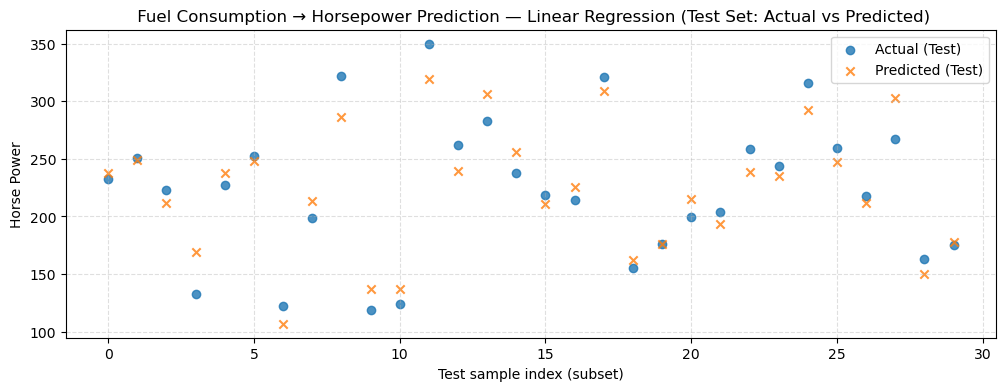


Scenario:  Fuel Consumption → Horsepower Prediction
Model: Polynomial Regression (degree=2)


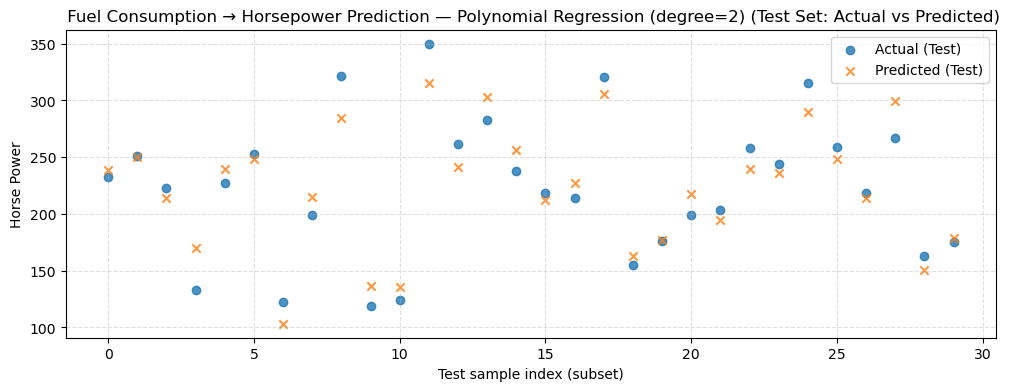


Scenario:  Fuel Consumption → Horsepower Prediction
Model: Polynomial Regression (degree=3)


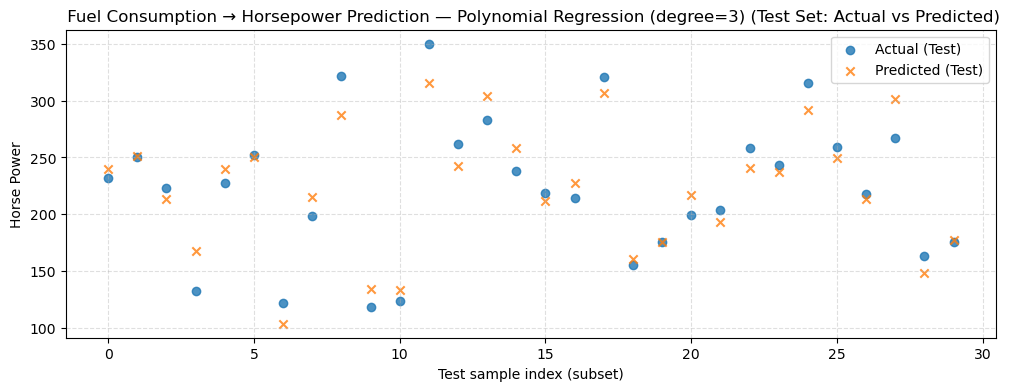


Scenario:  Fuel Consumption → Horsepower Prediction
Model: Polynomial Regression (degree=4)


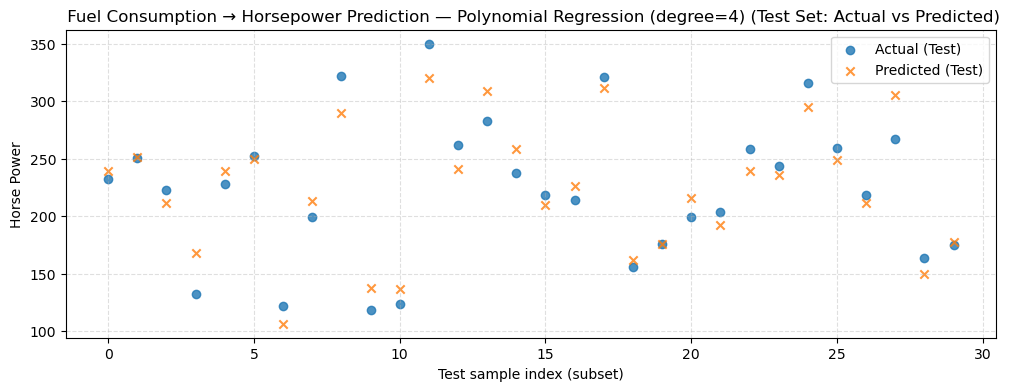

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Fuel Consumption → Horsepower Prediction,Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561,70,30
1,Fuel Consumption → Horsepower Prediction,Polynomial Regression (degree=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118,70,30
2,Fuel Consumption → Horsepower Prediction,Polynomial Regression (degree=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604,70,30
3,Fuel Consumption → Horsepower Prediction,Polynomial Regression (degree=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868,70,30


In [88]:
df = df.copy()

results = run_models_and_evaluate(
    df,
    scenario_name= " Fuel Consumption → Horsepower Prediction",
    degrees=(1, 2, 3, 4),
    target_col=TARGET_COL_1,
    test_size=0.30,
    random_state=42,
    show_equation=False,   # optional (equations can be huge)
    show_plots=True,
    top_k_terms=15
)

display(results)

## 1.5 Discussion and interpretation (10 points)
1. Which model performs best on the test set and why?
- The model with degree 4 performs best on the test set.
- It achieves the lowest Test MSE (313.798757) and the highest Test R² (0.913868, close to 1) among all models.
- Those indicate that the degree-4 model has the smallest prediction error and explains largest proportion of variance in Horse Power.

2. Does increasing the polynomial degree always improve performance? If not, explain what you observe.
- Increasing the polynomial degree does not always improve test performance.
- From the results, the degree-2 model performs worse than linear regression, with a higher Test MSE (331.105434 vs. 318.561087) and lower Test R² (0.909118 vs. 0.912561).
- Compare higher-degree models (degrees 3 and 4), increasing the polynomial-degree slightly improve test performance.

3. If a model performs unexpectedly poorly (e.g., low R2 or large test error), propose at least two plausible reasons, such as:
– underfitting vs overfitting,
– weak relationship between features and target,
– outliers or noise in the data,
– insufficient feature information for predicting HP.

- None of the models performs unexpectedly poorly
- Linear Regression and Polynomial Regression with degree 2 have high Train and Test Error. However, there is no strong evidence of underfitting or overfitting, because the difference between training and testing Error is small.
- The high R^2 values indicate a strong relationship between fuel economy and horsepower.

4. Support your claims using your reported metrics (not intuition only).

# Part 2 (50 points): Weather → Daily Electricity Consumption Prediction
Dataset: Electricity Consumption Based On Weather Data (Kaggle)
Goal: Build regression models to predict daily electricity consumption using weather features.

## 2.1 Load and inspect the dataset (10 points)

In [95]:
DATA_PATH_2 = "electricity_consumption_based_weather_dataset.csv"

df_2 = pd.read_csv(DATA_PATH_2)

print("Shape:", df_2.shape)
print("\nColumns:")
print(df_2.columns.tolist())

display(df_2.head())

print("\nSummary statistics:")
display(df_2.describe(include="all"))

print("\nMissing values per column:")
display(df_2.isna().sum())

Shape: (1433, 6)

Columns:
['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748



Summary statistics:


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1433,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
unique,1433,NaN,NaN,NaN,NaN,NaN
top,2010-11-26,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.642313,3.800488,17.187509,9.141242,1561.078061
std,NaN,1.140021,10.973436,10.136415,9.028417,606.819667
min,NaN,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,NaN,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,NaN,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,NaN,3.300000,1.300000,26.100000,17.200000,1893.608000



Missing values per column:


date                  0
AWND                 15
PRCP                  0
TMAX                  0
TMIN                  0
daily_consumption     0
dtype: int64

- AWND has 15 missing entries
- `df_clean = df_in.dropna().copy()` in `prepare_xy` is used to handle missing values consistently by dropping the affected rows.

## 2.2 - 2.4:


Scenario: Weather → Daily Electricity Consumption Prediction
Model: Linear Regression


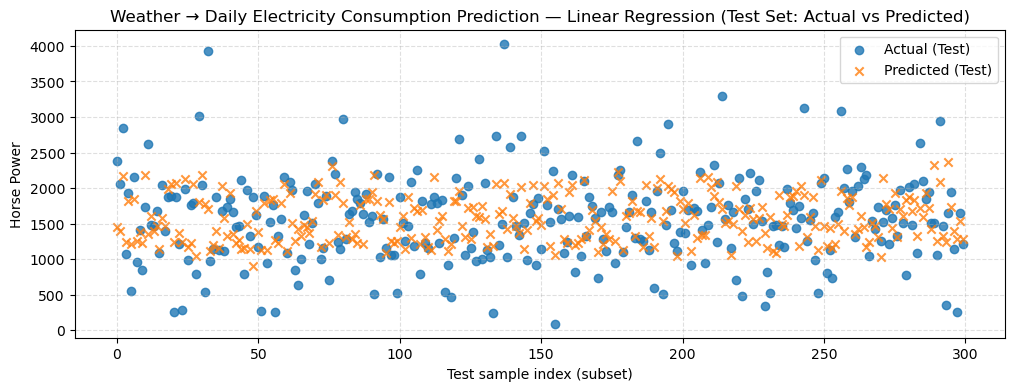


Scenario: Weather → Daily Electricity Consumption Prediction
Model: Polynomial Regression (degree=2)


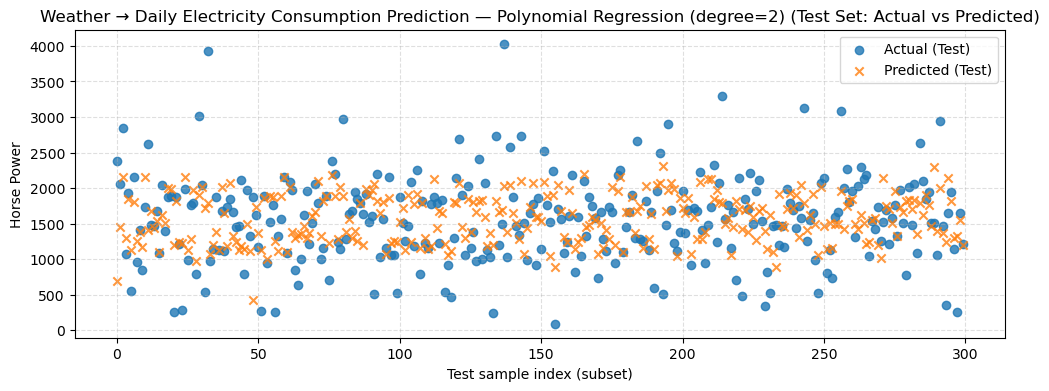


Scenario: Weather → Daily Electricity Consumption Prediction
Model: Polynomial Regression (degree=3)


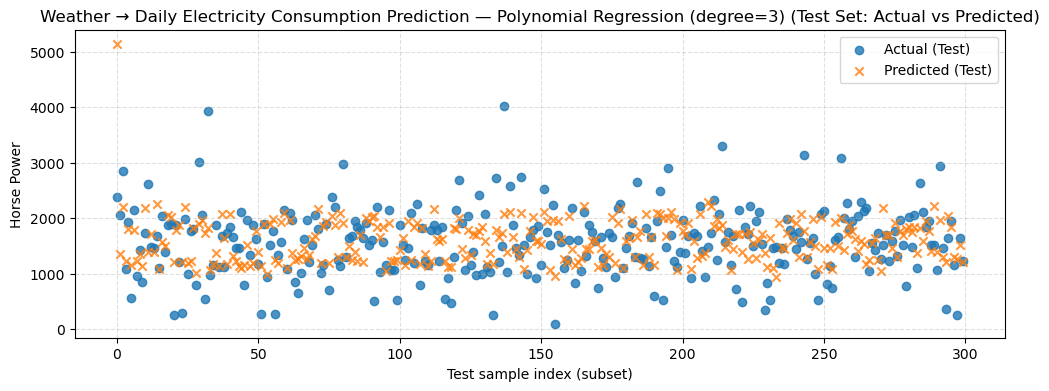


Scenario: Weather → Daily Electricity Consumption Prediction
Model: Polynomial Regression (degree=4)


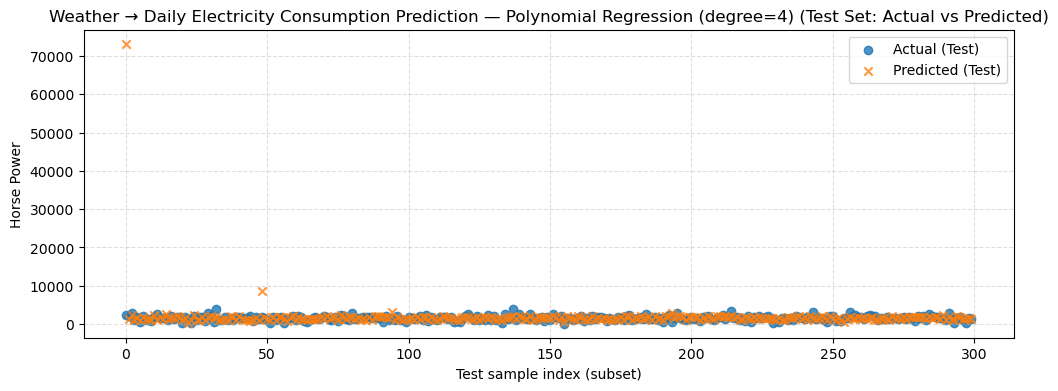

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Weather → Daily Electricity Consumption Predic...,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333,992,426
1,Weather → Daily Electricity Consumption Predic...,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163,992,426
2,Weather → Daily Electricity Consumption Predic...,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922,992,426
3,Weather → Daily Electricity Consumption Predic...,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844,992,426


In [96]:
df = df_2.drop(columns=["date"]).copy()

results = run_models_and_evaluate(
    df,
    scenario_name= "Weather → Daily Electricity Consumption Prediction",
    degrees=(1, 2, 3, 4),
    target_col=TARGET_COL_2,
    test_size=0.30,
    random_state=42,
    show_equation=False,   # optional (equations can be huge)
    show_plots=True,
    top_k_terms=15
)

display(results)

## 2.5 Discussion and interpretation (10 points)
Write a short, technical discussion that uses your results to answer:
1. Which model generalizes best (best test performance), and what does that tell you about the relationship between weather and electricity usage?
- Linear Regression has the best test performance.
- Because it has the highest R^2 (0.299333) and lowest Test MAE (375.404537) compared to the polynomial models.
- The small value of R^2 indicates that the relationship between weather and daily electricity consumption is weak and approximately linear.

2. Do polynomial models improve the fit compared to linear regression? If yes, why might electricity consumption have nonlinear dependence on weather?
- No, polynomial models do not improve the fit.
- As the polynomial degree increases from 1 to 4, Test MSE and Test MAE increase, while Test R^2 decreases. 

3. If higher-degree models perform worse on the test set, explain this behavior using evidence from metrics (e.g., train error decreases but test error increases).
- Training MSE decreases and testing MSE increases as the polynomial degree increases
- It is a behavior of overfitting.

4. If none of the models achieve good test performance, provide at least two reasons supported by your outputs (e.g., limited feature set, high noise, unmodeled drivers such as occupancy/behavior, seasonal effects).
- Limited feature set: The feature set includes only weather variables. However, daily electricity consumption is also influenced by other factors such as building type and economic factors.

- high noise: Even if the weather variables are measured correctly, they are not sufficient to explain all variations in daily electricity consumption. Human behavior, such as whether people stay at home and differences in usage habits, introduces significant noise.